### 2025 02 12

This notebook is only for training a new model. An already trained model is saved in the yolov5 folder.

# Image Labelling
- Must create a selection of frames from the videos
- use labelimg to label the mice in the images
- changes that we have to keep in mind from Nicholas Renotte's image labelling notebook for tensorflow:
    - must save labels in YOLO format instead of tensorflow. Yolo uses text files instead of xml

### 1. Video to training images, image labelling
#### Import dependencies for section one

In [5]:
!pip install opencv-python # note that the '!' runs this as a bash command line prompt instead of in python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/30/9b24a6e7021447788fa89ae5c215fb5c17b893585ddc6ac553632cc1b761/opencv_python-4.8.0.74-cp37-abi3-macosx_10_16_x86_64.whl.metadata
  Obtaining dependency information for numpy>=1.21.2 from https://files.pythonhosted.org/packages/fa/07/c6980120967a9fc76138eddd583d6ac47dd072922d6f66d7d502f6f9a964/numpy-1.25.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata
Using cached opencv_python-4.8.0.74-cp37-abi3-macosx_10_16_x86_64.whl (54.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 19.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2
import time

#### Set up folders
- for holding frames from training videos
- for holding image labels

In [5]:
import os
ROOT = os.getcwd()
VIDEOS_PATH = os.path.join('training_videos') # if want sub-folders then the os.path.join can be used for a series of strings with the folder names
IMAGES_PATH = os.path.join('data','images')
LABELS_PATH = os.path.join('data','labels')
if not os.path.exists(IMAGES_PATH):
    if os.name == 'posix':
        !mkdir -p {IMAGES_PATH}
if not os.path.exists(LABELS_PATH):
    if os.name == 'posix':
        !mkdir -p {LABELS_PATH}


#### Converting selected training videos to frames
- following guide from geeksforgeeks 'program to extract frames using OpenCV'
- created a python script 'video_to_frame.py' that takes a directory of videos to be sampled for frames and a directory for saving the frames

In [126]:
# works as of 230717
!python video_to_frame.py --load 'training_videos/' --save 'frames_test/'

Namespace(load='training_videos/', save='frames_test/')


#### Labelimg

In [5]:
LABELIMG_PATH = 'labelimg'
if not os.path.exists(LABELIMG_PATH):
    !mkdir {LABELIMG_PATH}
    !git clone https://github.com/tzutalin/labelImg {LABELIMG_PATH} # clone labelimg tool from github into new directory

In [89]:
%pip install --upgrade pyqt5 lxml

  Using cached PyQt5-5.15.9-cp37-abi3-macosx_10_13_x86_64.whl (7.0 MB)
  Obtaining dependency information for lxml from https://files.pythonhosted.org/packages/78/8d/96b95d704fab4a95651ceeb6022855ae5a3c631f86c6647749a2e868af92/lxml-4.9.3-cp310-cp310-macosx_11_0_x86_64.whl.metadata
  Using cached PyQt5_sip-12.12.1-cp310-cp310-macosx_10_9_universal2.whl (142 kB)
  Using cached PyQt5_Qt5-5.15.2-py3-none-macosx_10_13_intel.whl (40.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [95]:
!cd {LABELIMG_PATH} && make qt5py3

pyrcc5 -o libs/resources.py resources.qrc


In [97]:
# this will open the labelimg function
# label the images and then close when finished
!cd {LABELIMG_PATH} && python labelImg.py

Image:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/frames/vid0frame0.jpg -> Annotation:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/labels/vid0frame0.txt
Image:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/frames/vid0frame1000.jpg -> Annotation:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/labels/vid0frame1000.txt
Image:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/frames/vid0frame2000.jpg -> Annotation:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/labels/vid0frame2000.txt
Image:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/frames/vid0frame3000.jpg -> Annotation:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/labels/vid0frame3000.txt
Image:/Users/brennanwadsworth/VSCodeProjects/Mouse_Treadmill_Computer_Vision/frames/vid0frame4000.jpg -> Annotation:/Users/brennanwadsworth/VSCodeProjects/Mou

### 2. Model training
#### Install dependencies for section 2

In [116]:
%pip install torch torchvision torchaudio

  Using cached torch-2.0.1-cp310-none-macosx_10_9_x86_64.whl (143.4 MB)
  Using cached torchvision-0.15.2-cp310-cp310-macosx_10_9_x86_64.whl (1.5 MB)
  Using cached torchaudio-2.0.2-cp310-cp310-macosx_10_9_x86_64.whl (3.9 MB)
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/00/45/ec3407adf6f6b5bf867a4462b2b0af27597a26bd3cd6e2534cb6ab029938/filelock-3.12.2-py3-none-any.whl.metadata
  Obtaining dependency information for typing-extensions from https://files.pythonhosted.org/packages/ec/6b/63cc3df74987c36fe26157ee12e09e8f9db4de771e0f3404263117e75b95/typing_extensions-4.7.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 19.1 MB/s eta 0:00:0000:0100:01
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0b

In [40]:
YOLO_PATH = 'yolov5'
if not os.path.exists(YOLO_PATH):
    !mkdir {YOLO_PATH}
    !git clone https://github.com/ultralytics/yolov5


Cloning into 'yolov5'...
remote: Enumerating objects: 15814, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 15814 (delta 9), reused 23 (delta 2), pack-reused 15768
Receiving objects: 100% (15814/15814), 14.64 MiB | 7.51 MiB/s, done.
Resolving deltas: 100% (10821/10821), done.


In [113]:
# install yolov5 dependencies
# see yolov5/requirements/requirements.txt, which comes with the specific version of yolov5 that was imported
%pip install pyqt5==5.14.1
%pip install lxml==4.9.1

Note: you may need to restart the kernel to use updated packages.
  Using cached lxml-4.9.1.tar.gz (3.4 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lxml: filename=lxml-4.9.1-cp310-cp310-macosx_12_0_x86_64.whl size=1695679 sha256=30651e126340428af77641256f9e5ff2115fb7a2b7a42871885fa9d64426abac
  Stored in directory: /Users/brennanwadsworth/Library/Caches/pip/wheels/a4/ec/7b/8acde6da24b5aabeee049213d5bec12d1e9214d3cae276387b
Successfully built lxml
  Attempting uninstall: lxml
    Found existing installation: lxml 4.9.3
    Uninstalling lxml-4.9.3:
      Successfully uninstalled lxml-4.9.3
Note: you may need to restart the kernel to use updated packages.


In [24]:
%pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/c7/63/912f283f0a18bb6e909f6df2437e5e9216e872540a715a344d12108c0c2b/ultralytics-8.0.136-py3-none-any.whl.metadata
  Obtaining dependency information for scipy>=1.4.1 from https://files.pythonhosted.org/packages/b1/64/67efd36ed232b9b107ad8435d0f0ebec28e5e6f782ededbd1ab4a37a0100/scipy-1.11.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 1.4 MB/s eta 0:00:00
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.4/605.4 kB 10.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 13.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [3]:
# loading the specific model that we want to leverage
# first input is the general umbrella of model version
# second input selects the specific yolov5 model to alter the computing speed etc.
model = torch.hub.load('ultralytics/yolov5','yolov5s') 

Using cache found in /Users/brennanwadsworth/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

YOLOv5 🚀 2023-7-17 Python-3.10.12 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [4]:
# check that model was actually loaded - should see some lines describing convolution layers and SiLU (sigmoid linear units) activation functions
model

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

We can test the model already, it almost certainly won't work.
- select an image within the frames directory
- pass the image to the model and assign the results to a variable named results
- results.print() will show the image shape and what the model identified

In [5]:
for roots, dirs, files in os.walk(IMAGES_PATH):
    imgs = files
for roots, dirs, files in os.walk(LABELS_PATH):
    labels = files
img = IMAGES_PATH+'/'+imgs[0]
img

'data/images/.DS_Store'

In [45]:
results = model(img)
results.print()

image 1/1: 240x320 1 oven, 1 refrigerator
Speed: 12.6ms pre-process, 172.7ms inference, 2.3ms NMS per image at shape (1, 3, 480, 640)


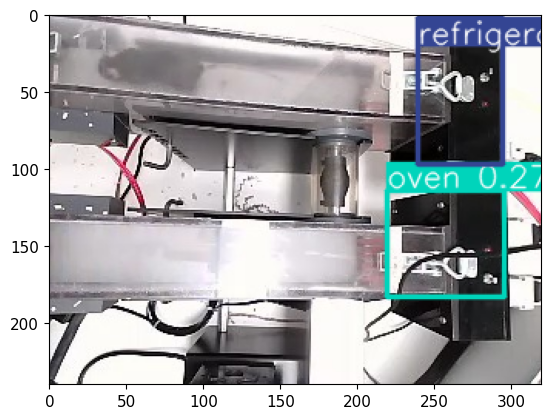

In [46]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

Now that the model is loaded, on to model training

In [ ]:
# create dataset.yaml file

In [130]:
!cd yolov5 && python train.py  --img 320 --batch 16 --epochs 100 --data dataset.yaml --weights yolov5s.pt

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[

#### Load and apply model

In [3]:
# enter the desired experiment from yolov5/runs/train
# this is telling yolov5 that we want to use a custom model, and then we tell it which weights to use
model_trained = torch.hub.load('ultralytics/yolov5','custom',path='yolov5/runs/train/exp2/weights/best.pt')

Using cache found in /Users/brennanwadsworth/.cache/torch/hub/ultralytics_yolov5_master
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

YOLOv5 🚀 2023-7-17 Python-3.10.12 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


Same code as above, input images to the trained model and see if it can pick out the mouse

In [6]:
IMAGES_PATH = os.path.join('data','val','images')
for roots, dirs, files in os.walk(IMAGES_PATH):
    imgs = files
for roots, dirs, files in os.walk(LABELS_PATH):
    labels = files
img = IMAGES_PATH+'/'+imgs[40]
img
results = model_trained(img)
results.print()

image 1/1: 240x320 1 mouse, 1 blue_line
Speed: 410.7ms pre-process, 149.4ms inference, 2.6ms NMS per image at shape (1, 3, 480, 640)


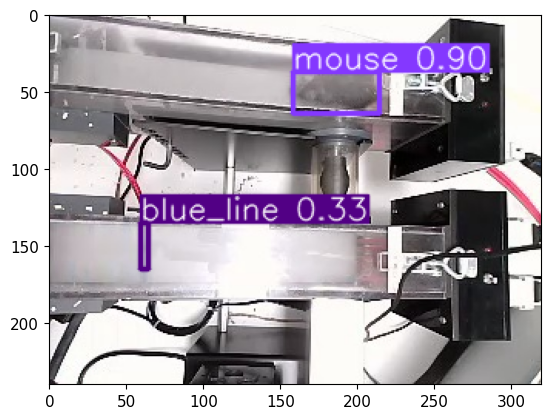

In [7]:
%matplotlib inline 
plt.imshow(np.squeeze(results.render()))
plt.show()

In [153]:
results.pred[0:] #output is x1, y1, x2, y2, confidence, class (15 = mouse, 16 = blue_line)

[tensor([[158.90680,  37.09623, 214.47906,  64.54944,   0.89864,  15.00000],
         [ 59.74303, 135.14592,  64.74553, 165.93910,   0.33326,  16.00000]])]

## Detection
#### Idea now is to load a video, read it frame by frame, record the instances of mouse and blue_line, and track their position.


In [8]:
# reproduce model_trained variable
model_trained = torch.hub.load('ultralytics/yolov5','custom',path='yolov5/runs/train/exp2/weights/best.pt')

Using cache found in /Users/brennanwadsworth/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-7-17 Python-3.10.12 torch-2.0.1 CPU

Fusing layers... 
Model summary: 157 layers, 7055974 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


In [47]:
os.chdir(ROOT)
VIDEOS_PATH = "/Volumes/Backup_Plus/RSJ_Lab/Treadmill_Videos/TA_BW_ECC Pilot"
RESULTS_PATH = os.path.join('results')
if not os.path.exists(RESULTS_PATH):
    if os.name == 'posix':
        !mkdir -p {RESULTS_PATH}

for roots, dirs, files in os.walk(VIDEOS_PATH):
    videos = files
print(f'{len(videos)} videos for analysis')
for video in videos:
    print(video)
    os.chdir(ROOT)
    vidObj = cv2.VideoCapture(os.path.join(VIDEOS_PATH,video)) # collects video object in cv2 framework
    df = pd.DataFrame(columns=['frame', 'xmin','ymin','xmax','ymax','confidence','class','name'])
    success = True
    count = 0
    while success:
        success, img = vidObj.read() # this will step by step read each frame of the video
        if success and count % 30 == 0:
            results = model_trained(img)
            df = pd.concat([df,results.pandas().xyxy[0].join(pd.Series([count] * results.pandas().xyxy[0].shape[0], name="frame"))],ignore_index=True)
        count += 1
    os.chdir(RESULTS_PATH)
    df.to_csv(f'{video}_tracking_results.csv')


4 videos for analysis
WIN_20250130_09_19_58_Pro.mp4
._WIN_20250130_09_19_58_Pro.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7f81f3388900] moov atom not found
OpenCV: Couldn't read video stream from file "/Volumes/Backup_Plus/RSJ_Lab/Treadmill_Videos/TA_BW_ECC Pilot/._WIN_20250130_09_19_58_Pro.mp4"


WIN_20250131_08_33_20_Pro.mp4
._WIN_20250131_08_33_20_Pro.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x7f81f32c5640] moov atom not found
OpenCV: Couldn't read video stream from file "/Volumes/Backup_Plus/RSJ_Lab/Treadmill_Videos/TA_BW_ECC Pilot/._WIN_20250131_08_33_20_Pro.mp4"


In [4]:

!cd yolov5 && python detect.py  --img 320 --data dataset_detect.yaml --weights runs/train/exp2/weights/best.pt --save-txt --save-conf --vid-stride 30
# videos were captured in 30 frames per second
# this code shows that it is possible to give yolov5 a video and it will already conduct the detections for each frame within the vide.
# this code will also create a new video showing the model-detected bounding boxes, so nice to have! 
# this bash line call saves each detection to a text file instead of a variable that we can use here, so best to create a new code line here

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

detect: weights=['runs/train/exp2/weights/best.pt'], source=data/images, data=dataset_detect.yaml, imgsz=[320, 320], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=30
YO